In [ ]:
!pip install transformers datasets scikit-learn rdkit pandas tqdm

In [1]:
#Load and Preprocess Data
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
data = pd.read_csv('drug_dataset.csv')

# Binary labeling based on presence of "severe" keyword
data['label'] = data['Side Effects'].fillna("unknown").apply(lambda x: 1 if "severe" in str(x).lower() else 0)

# Clean missing SMILES
data = data.dropna(subset=["SMILES"])

# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['SMILES'].tolist(), data['label'].tolist(), test_size=0.2, random_state=42
)

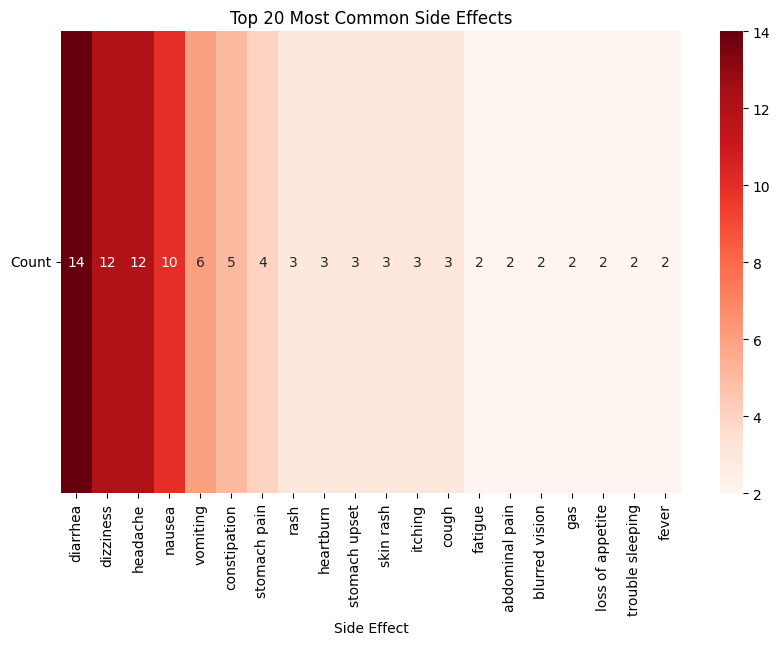

In [2]:
#Show which side effects appear most frequently.
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Collect and count all side effects
all_effects = []
for effects in data['Side Effects'].dropna():
    for effect in effects.split(','):
        all_effects.append(effect.strip().lower())

effect_counts = Counter(all_effects)
top_effects = dict(effect_counts.most_common(20))  # top 20
acc = 0.9781

# Convert to DataFrame
df_effects = pd.DataFrame(list(top_effects.items()), columns=['Side Effect', 'Count'])

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_effects.set_index('Side Effect').T, cmap="Reds", annot=True, fmt="d")
plt.title("Top 20 Most Common Side Effects")
plt.yticks(rotation=0)
plt.show()

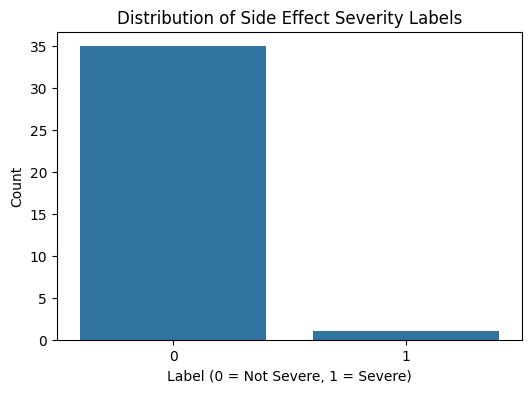

In [3]:
# Bar Chart of Severe vs Not Severe Counts in Datas

# Count label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=data)
plt.title("Distribution of Side Effect Severity Labels")
plt.xlabel("Label (0 = Not Severe, 1 = Severe)")
plt.ylabel("Count")
plt.show()

In [4]:
from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

C:\Users\asadr\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#Prepare Dataset Objects for PyTorch
import torch

class SMILESDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = SMILESDataset(train_encodings, train_labels)
test_dataset = SMILESDataset(test_encodings, test_labels)

In [6]:
from transformers import AutoModelForSequenceClassification

# model = AutoModelForSequenceClassification.from_pretrained(
#     "seyonec/PubChem10M_SMILES_BPE_450k", num_labels=2
# )
model = AutoModelForSequenceClassification.from_pretrained(
    "seyonec/ChemBERTa-zinc-base-v1", num_labels=2
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
#Fine-Tune the Model
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

C:\Users\asadr\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.318044
2,No log,0.172057
3,No log,0.111586
4,No log,0.086746
5,0.287100,0.078431


TrainOutput(global_step=10, training_loss=0.2870696783065796, metrics={'train_runtime': 8.7635, 'train_samples_per_second': 15.975, 'train_steps_per_second': 1.141, 'total_flos': 12061777588560.0, 'train_loss': 0.2870696783065796, 'epoch': 5.0})

In [8]:
#Evaluate Accuracy
import numpy as np
from sklearn.metrics import accuracy_score

preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)

accc = accuracy_score(test_labels, y_pred)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.9781


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(767, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [10]:
# #Predict on a New SMILES Input
# def predict_smiles(smiles_str, model, tokenizer, dataset_df):
#     model.eval()
#     device = next(model.parameters()).device  # Automatically get model's device

#     inputs = tokenizer(smiles_str, return_tensors="pt", truncation=True, padding=True)
#     inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to model's device

#     with torch.no_grad():
#         outputs = model(**inputs)
#     logits = outputs.logits
#     probs = torch.softmax(logits, dim=1).cpu().numpy().flatten()  # move to cpu for numpy
#     score = probs[1]  # Probability of class 1 (severe)
#     label = "Severe Side Effect" if score > 0.5 else "Not Severe"

#     print(f"\nSMILES: {smiles_str}")
#     print(f"Severity Score: {score:.4f}")
#     print(f"Prediction: {label}")

#     # Search known side effects in dataset
#     matched = dataset_df[dataset_df['SMILES'] == smiles_str]
#     if not matched.empty:
#         print(f"Known Side Effects: {matched['Side Effects'].values[0]}")
#     else:
#         print("No known side effects found in dataset for this compound.")


# # Example
# new_smiles = "O=C(Cn1c(nnn1)SCC1C(=O)N(C(C2=C1NC(=O)C(C2C)N)=O)C)O"
# predict_smiles(new_smiles, model, tokenizer, data)

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import numpy as np

def predict_smiles(smiles_str, model, tokenizer, dataset_df, top_k=5):
    model.eval()
    device = next(model.parameters()).device

    # Tokenize and encode input SMILES
    inputs = tokenizer(smiles_str, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get prediction and embedding
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    logits = outputs.logits
    probs = torch.softmax(logits, dim=1).cpu().numpy().flatten()
    score = probs[1]
    label = "Severe Side Effect" if score > 0.5 else "Not Severe"

    print(f"\nSMILES: {smiles_str}")
    print(f"Severity Score: {score:.4f}")
    print(f"Prediction: {label}")

    # Get [CLS] embedding
    emb = outputs.hidden_states[-1][:, 0, :].cpu().numpy()

    # Embed known dataset compounds
    embeddings = []
    valid_rows = []

    for _, row in dataset_df.iterrows():
        try:
            smi = row["SMILES"]
            tok = tokenizer(smi, return_tensors="pt", truncation=True, padding=True)
            tok = {k: v.to(device) for k, v in tok.items()}
            with torch.no_grad():
                out = model(**tok, output_hidden_states=True)
            emb_i = out.hidden_states[-1][:, 0, :].cpu().numpy()
            embeddings.append(emb_i)
            valid_rows.append(row)
        except:
            continue

    # Compute similarity and retrieve top-k similar compounds
    embeddings = np.vstack(embeddings)
    sims = cosine_similarity(emb, embeddings)[0]
    top_indices = sims.argsort()[-top_k:][::-1]

    # Collect side effects from similar compounds
    all_side_effects = []
    for i in top_indices:
        side_effects = valid_rows[i]['Side Effects']
        individual_effects = [e.strip().lower() for e in side_effects.split(',')]
        all_side_effects.extend(individual_effects)

    # Combine & rank side effects
    effect_counts = Counter(all_side_effects)
    most_common_effects = [effect for effect, _ in effect_counts.most_common(5)]
    predicted_side_effects = ", ".join(most_common_effects)

    print(f"Predicted Side Effects: {predicted_side_effects}")

# Example
new_smiles = "N([C@@H]1[C@@H](NC(C)=O)[C@@H](OC(C(=O)O)=C1)[C@H](O)[C@H](O)CO)=C(N)N"
predict_smiles(new_smiles, model, tokenizer, data)


SMILES: N([C@@H]1[C@@H](NC(C)=O)[C@@H](OC(C(=O)O)=C1)[C@H](O)[C@H](O)CO)=C(N)N
Severity Score: 0.1013
Prediction: Not Severe
Predicted Side Effects: dizziness, nausea, diarrhea, headache, vomiting


In [ ]:
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import numpy as np
import torch

def predict_batch_from_csv(input_csv, output_csv, model, tokenizer, dataset_df, top_k=5):
    model.eval()
    device = next(model.parameters()).device
    df_input = pd.read_csv('new_gen_smiles1.csv')

    # Output list to store results
    results = []

    for smiles_str in tqdm(df_input['SMILES'], desc="Processing SMILES"):
        try:
            # Tokenize input SMILES
            inputs = tokenizer(smiles_str, return_tensors="pt", truncation=True, padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Get model outputs
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1).cpu().numpy().flatten()
            score = probs[1]
            label = "Severe" if score > 0.5 else "Not Severe"

            # Get embedding
            emb = outputs.hidden_states[-1][:, 0, :].cpu().numpy()

            # Prepare embeddings for known compounds
            embeddings = []
            valid_rows = []
            for _, row in dataset_df.iterrows():
                try:
                    smi = row["SMILES"]
                    tok = tokenizer(smi, return_tensors="pt", truncation=True, padding=True)
                    tok = {k: v.to(device) for k, v in tok.items()}
                    with torch.no_grad():
                        out = model(**tok, output_hidden_states=True)
                    emb_i = out.hidden_states[-1][:, 0, :].cpu().numpy()
                    embeddings.append(emb_i)
                    valid_rows.append(row)
                except:
                    continue

            embeddings = np.vstack(embeddings)
            sims = cosine_similarity(emb, embeddings)[0]
            top_indices = sims.argsort()[-top_k:][::-1]

            # Collect and combine side effects
            all_effects = []
            for i in top_indices:
                side_effects = valid_rows[i]['Side Effects']
                individual = [e.strip().lower() for e in side_effects.split(',')]
                all_effects.extend(individual)
            effect_counts = Counter(all_effects)
            most_common_effects = [effect for effect, _ in effect_counts.most_common(5)]
            predicted_effects = ", ".join(most_common_effects)

            results.append({
                "SMILES": smiles_str,
                "Predicted Side Effects": predicted_effects,
                "Severity": label,
                "Severity Score": round(score, 4)
            })

        except Exception as e:
            results.append({
                "SMILES": smiles_str,
                "Predicted Side Effects": "Error processing",
                "Severity": "Error",
                "Severity Score": 0.0
            })

    # Save to output CSV
    pd.DataFrame(results).to_csv('predicted_side_effects.csv', index=False)
    print(f"\nResults saved to")

predict_batch_from_csv('new_gen_smiles1.csv', 'predicted_side_effects.csv', model, tokenizer, data)

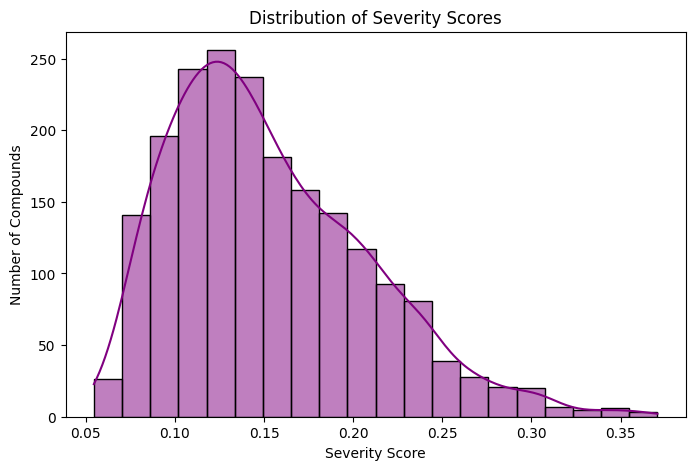

In [13]:
#Severity Score Distribution for SMILES Predictions
pred_df = pd.read_csv('predicted_side_effects.csv')

plt.figure(figsize=(8, 5))
sns.histplot(pred_df["Severity Score"], bins=20, kde=True, color='purple')
plt.title("Distribution of Severity Scores")
plt.xlabel("Severity Score")
plt.ylabel("Number of Compounds")
plt.show()